In [1]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_calibrations.ipynb

[NbConvertApp] Converting notebook compare_calibrations.ipynb to python
[NbConvertApp] Writing 12515 bytes to compare_calibrations.py


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn
from glob import glob
from ridgereliability import metrics, plots
import sklearn.model_selection
import sklearn.metrics
from dirichlet.calib import tempscaling, vectorscaling
from dirichlet import DirichletCalibrator
from sklearn.base import clone
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils import check_X_y, indexable, column_or_1d
from sklearn.utils.validation import check_is_fitted

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from enum import Enum
class F(Enum):
    TRAIN = 1
    EVAL = 2

In [4]:
f = F.EVAL
epochs = 40

In [5]:
if f is F.TRAIN:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--out", type=str, required=True)
    output_dir = parser.parse_args().out
elif f is F.EVAL:
    output_dir = "/home/maximl/Data/Experiment_data/results/riverrel/models_40epochs/"

# Compare calibration methods on CIFAR-10

We hypothesize that the PEACE metric and posterior reliability diagram will be better measures for finding an optimal post-hoc calibration method. Since PEACE is computed using full posterior balanced accuracy distributions, it takes into account the variance of probability estimates in each bin. This means using PEACE we can select a calibration method that produces probability estimates with high certainty, something we can not check with ECE.

Here, we test this hypothesis by calibrating a DenseNet trained on CIFAR-10 with temperature scaling and Platt scaling. We begin by loading a baseline model and evaluating it. Then, we do the same for calibrated models.

In [6]:
if f is F.TRAIN:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                print(gpu)
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
    dev = [d for d in tf.config.experimental.list_logical_devices() if d.device_type=="GPU"][0]

In [7]:
# noscript
if f is F.EVAL:
    from collections import namedtuple
    device = namedtuple("device", ["name"])
    dev = device(name="/CPU:0")

## Load CIFAR-10

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

mean = x_train.mean()
std = x_train.std()

x_test = (x_test - mean) / (std + 1e-7)
y_test = tf.keras.utils.to_categorical(y_test)

x_train = (x_train - mean) / (std + 1e-7)
y_train = tf.keras.utils.to_categorical(y_train)

## Train baseline uncalibrated DenseNet

We will first train two models:  
- One is trained on the full train set, and will be used as a baseline model.
- The other is trained on the smaller version of the full train set from which validation data is held-out for calibration. On this model we will apply post-hoc calibration methods.

In [9]:
models = {}

In [10]:
if f is F.TRAIN:
    with tf.device(dev.name):
        model = tf.keras.applications.DenseNet121(
            include_top=True,
            weights=None,
            classes=10,
            input_shape=[32, 32, 3]
        )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])

    model.save_weights(os.path.join(output_dir, 'model.h5'))

### Train on the full train set

In [11]:
if f is F.TRAIN:
    with tf.device(dev.name):
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    featurewise_center=False,  # set input mean to 0 over the dataset
                    samplewise_center=False,  # set each sample mean to 0
                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                    samplewise_std_normalization=False,  # divide each input by its std
                    zca_whitening=False,  # apply ZCA whitening
                    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                    horizontal_flip=True,  # randomly flip images
                    vertical_flip=False)  # randomly flip images

In [12]:
if f is F.TRAIN:
    logging.info("Training baseline on full train set")
    
    datagen.fit(x_train)
    model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch=np.ceil(len(x_train)/128)
    )
    
    models["baseline"] = model
    model.save(os.path.join(output_dir, 'baseline.h5'))

In [13]:
#noscript
if f is F.EVAL:
    with tf.device(dev.name):
        models["baseline"] = tf.keras.models.load_model(os.path.join(output_dir, 'baseline.h5'))

### Evaluate model

In [14]:
calibration_metrics = {}

In [15]:
def evaluate_model(model, x_test, y_test, keras=False, bins=15, verbose=0, y_probs=None):
    
    if keras:
        y_probs = model.predict(x_test, batch_size=128, verbose=verbose)
    else:
        y_probs = model.predict_proba(x_test)
    y_probs_max = y_probs.max(axis=1)
    y_preds = y_probs.argmax(axis=1)
    y_test = y_test.argmax(axis=1)
    
    return {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        'ece': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
        'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
        'peace': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
        'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
        'class_wise_ece_balanced': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, balanced=True, bins=bins),
        'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
    }

In [43]:
calibration_metrics["baseline"] = evaluate_model(models["baseline"], x_test, y_test, keras=True)

/home/maximl/Data/dev/active/ridgereliability/ridgereliability/utils.py:83: UserWarning: Skipping bin since it contains less then 2 instances...
  warnings.warn("Skipping bin since it contains less then 2 instances...")
/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [16]:
# noscript
y_probs = models["baseline"].predict(x_test, batch_size=256, verbose=1)

40/40 [==============================] - 20s 492ms/step


In [18]:
# noscript
a = [[], [], [], []]
c = []
for b in range(1, 30):
    a[0].append(metrics.class_wise_error(y_probs, y_probs.argmax(axis=1), y_test.argmax(axis=1), metrics.ece, balanced=True, bins=b))
    a[1].append(metrics.class_wise_error(y_probs, y_probs.argmax(axis=1), y_test.argmax(axis=1), metrics.peace, bins=b))
    a[2].append(metrics.ece(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test.argmax(axis=1), balanced=True, bins=b))
    a[3].append(metrics.peace(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test.argmax(axis=1), bins=b))

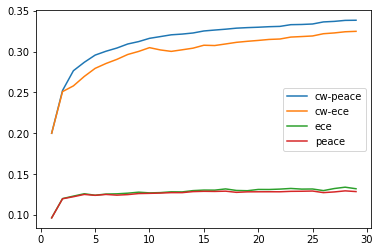

In [19]:
# noscript
x = range(1, 30)
plt.plot(x, a[0], label="cw-peace")
plt.plot(x, a[1], label="cw-ece")
plt.plot(x, a[2], label="ece")
plt.plot(x, a[3], label="peace")
plt.legend()

In [ ]:

del models["baseline"]

### Train on the small train set

In [ ]:
x_train_s, x_val, y_train_s, y_val = sklearn.model_selection.train_test_split(x_train, y_train.argmax(axis=1), test_size=0.25)

mean = x_train_s.mean()
std = x_train_s.std()

x_train_s = (x_train_s - mean) / (std + 1e-7)
y_train_s = tf.keras.utils.to_categorical(y_train_s)

x_val = (x_val - mean) / (std + 1e-7)
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
if f is F.TRAIN:
    logging.info("Training baseline on reduced train set")
    model.load_weights(os.path.join(output_dir, "model.h5"))

    datagen.fit(x_train_s)
    model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch=np.ceil(len(x_train)/128)
    )

    models["baseline_s"] = model
    model.save(os.path.join(output_dir, 'baseline_s.h5'))

In [ ]:
#noscript
if f is F.EVAL:
    with tf.device(dev.name):
        models["baseline_s"] = tf.keras.models.load_model(os.path.join(output_dir, 'baseline_s.h5'))

## Fit calibration methods on baseline (small)

In [ ]:
class CalibratedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, calibrator=None):
        ''' Initialize a Calibrated model (classifier + calibrator)

        Parameters
        ----------
        base_estimator : string
            Name of the classifier
        method : string
            Name of the calibrator
        '''
        self.base_estimator = base_estimator
        self.calibrator = calibrator

    def fit(self, X, y, X_val=None, y_val=None, *args, **kwargs):
        """Fit the calibrated model

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples, n_classes)
            Target values.

        Returns
        -------
        self : object
            Returns an instance of self.
        """

        X, y = indexable(X, y)

        scores = self.base_estimator.predict(X, batch_size=128, verbose=1)

        if X_val is not None:
            X_val, y_val = indexable(X_val, y_val)
            # TODO add scores of validation
            scores_val = self.base_estimator.predict(X_val, batch_size=128, verbose=1)
        else:
            scores_val = None

        self.calibrator.fit(scores, y, X_val=scores_val, y_val=y_val, *args, **kwargs)
        
        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification

        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.

        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """

        scores = self.base_estimator.predict(X, batch_size=256, verbose=1)

        predictions = self.calibrator.predict_proba(scores)

        return predictions

    def predict(self, X, *args):
        """Predict the target of new samples. Can be different from the
        prediction of the uncalibrated classifier.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.

        Returns
        -------
        C : array, shape (n_samples,)
            The predicted class.
        """
        check_is_fitted(self, ["calibrator"])
        return np.argmax(self.predict_proba(X), axis=1)
    

In [ ]:
reg_lambda_list = [1, 0.1 , 0.01, 0.001, 0.0001]
reg_mu_list = [1, 0.1, 0.01, 0.001]

In [ ]:
calibrators = {}

### Temperature Scaling

In [ ]:
logging.info("Temperature scaling started")

In [ ]:
calibrator = tempscaling.TemperatureScaling(reg_lambda_list=reg_lambda_list, reg_mu_list=reg_mu_list, logit_constant=0.0)
models["temperature"] = CalibratedModel(models["baseline_s"], calibrator)

In [ ]:
models["temperature"].fit(x_train_s, y_train_s.argmax(axis=1), X_val=x_val, y_val=y_val.argmax(axis=1), verbose=0)

In [ ]:
calibration_metrics["temperature"] = evaluate_model(models["temperature"], x_test, y_test)

In [ ]:
logging.info("Temperature scaling ended")

### Dirichlet calibration

In [ ]:
logging.info("Dirichlet calibration started")

In [ ]:
calibrator = DirichletCalibrator(matrix_type="full", l2=0.1)
models["dirichlet"] = CalibratedModel(models["baseline_s"], calibrator)
models["dirichlet"].fit(x_train_s, y_train_s.argmax(axis=1), X_val=x_val, y_val=y_val.argmax(axis=1), verbose=0)

In [ ]:
calibration_metrics["dirichlet"] = evaluate_model(models["dirichlet"], x_test, y_test)

In [ ]:
logging.info("Dirichlet calibration ended")

### Vector scaling

In [ ]:
logging.info("Vector scaling started")

In [ ]:
calibrator = vectorscaling.VectorScaling(reg_lambda_list=reg_lambda_list, reg_mu_list=reg_mu_list)
models["vector"] = CalibratedModel(models["baseline_s"], calibrator)
models["vector"].fit(x_train_s, y_train_s.argmax(axis=1), X_val=x_val, y_val=y_val.argmax(axis=1), verbose=0)

In [ ]:
calibration_metrics["vector"] = evaluate_model(models["vector"], x_test, y_test)

In [ ]:
logging.info("Vector scaling ended")

# Save calibrated models and metrics

In [ ]:
if f is F.TRAIN:
    for k, model in models.items():
        if type(model) is tf.python.keras.engine.functional.Functional:
            fname = os.path.join(output_dir, f"{k}.h5")
            model.save(fname)
        else:
            fname = os.path.join(output_dir, f"{k}.h5")
            model.base_estimator = None
            dump(model, fname)
            
    df = pd.DataFrame(calibration_metrics).T
    dump(df, os.path.join(output_dir, "calibration_metrics.dat"))

# Model comparison

In [ ]:
if f is F.TRAIN:
    exit()

In [9]:
experiments_dir = "/home/maximl/Data/Experiment_data/results/riverrel/models/compare_calibrations/"

In [10]:
df = []
for p in os.listdir(experiments_dir):
    fn = os.path.join(experiments_dir, p, "calibration_metrics.dat")
    
    df.append(load(fn))
    
df = pd.concat(df).reset_index()

In [11]:
dfs = []
for col in df.columns[-6:]:
    dfs.append(
        pd.DataFrame(
            dict(value=df[col], method=df["index"], metric=col)
        )
    )
longform_df = pd.concat(dfs)

In [13]:
longform_df.head()

,value,method,metric
0,0.073571,baseline,ece
1,0.073154,temperature,ece
2,0.078160,dirichlet,ece
3,0.063847,vector,ece
4,0.073698,baseline,ece


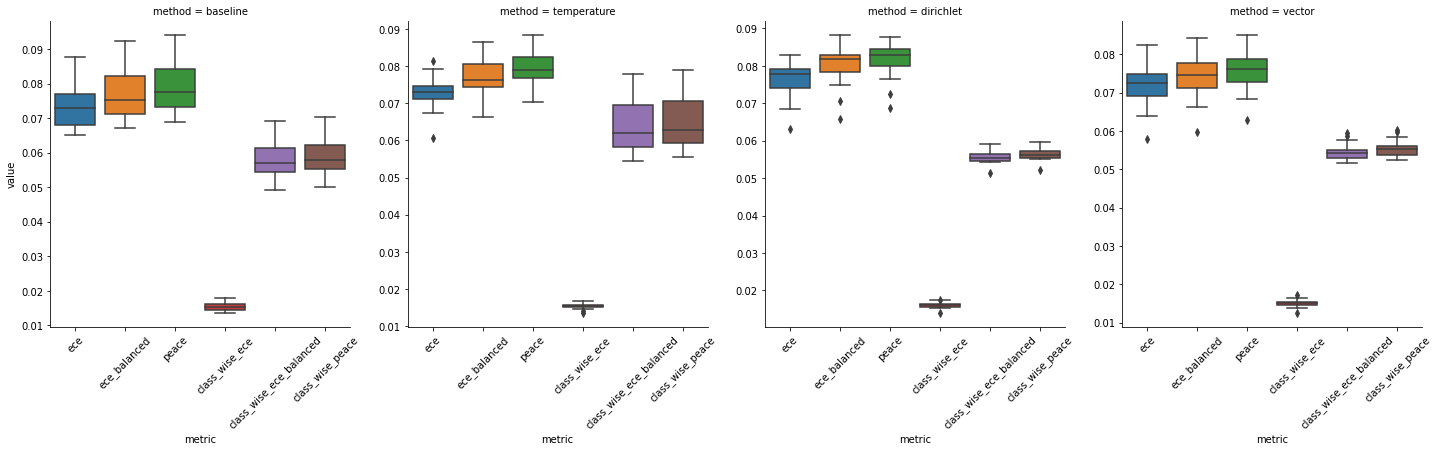

In [20]:
a = seaborn.catplot(data=longform_df, x="metric", y="value", col="method", kind="box", sharey=False)
a.set_xticklabels(rotation=45)

In [18]:
df.index[df["peace"].argmin()], df["peace"].min()

('baseline', 0.07642978118399542)

In [19]:
df.index[df["class_wise_peace"].argmin()], df["class_wise_peace"].min()

('vector', 0.05590851314676567)

In [20]:
df.index[df["ece"].argmin()], df["ece"].min()

('baseline', 0.07539926948696371)

In [21]:
df.index[df["class_wise_ece"].argmin()], df["class_wise_ece"].min()

('vector', 0.015530941661122486)

fig, axes = plt.subplots(1, len(models), figsize=(len(models)*3, 3), constrained_layout=True)
for ax, (k, model) in zip(axes, models.items()):
    
    ax.set_title(k)
    
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(x_test)
    else:
        y_probs = model.predict(x_test, batch_size=256, verbose=1)
    y_probs_max = y_probs.max(axis=1)
    y_preds = y_probs.argmax(axis=1)
    
    plots.posterior_reliability_diagram(y_probs_max, y_preds, y_test.argmax(axis=1), bins=15, ax=ax)

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(25, 6), sharex=True, sharey=True, constrained_layout=True)
for row, (k, model) in zip(axes, {k:v for k,v in models.items() if k in ["temperature", "vector"]}.items()):

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(x_test)
    else:
        y_probs = model.predict(x_test, batch_size=256, verbose=1)
    y_preds = y_probs.argmax(axis=1)

    plots.class_wise_posterior_reliability_diagram(y_probs, y_preds, y_test.argmax(axis=1), bins=10, axes=row, metric=metrics.peace)
    
    row[0].set_ylabel(k + "\n" + row[0].get_ylabel())